In [1]:
import tensorflow as tf
import numpy as np 
import gym
from gym.spaces import Discrete, Box

In [2]:
def mlp(x, sizes, activation=tf.tanh, output_activation=None):

    # building a feedforward neural network.
    for size in sizes[:-1]:
        x = tf.layers.dense(x, units=size, activation=activation)
    return tf.layers.dense(x, units=sizes[-1], activation=output_activation)

In [3]:
def train(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2,
         epochs=50, batch_size=5000, render=True):
    
    # make environment,check spaces, get obs / act dims
    env = gym.make(env_name)
    assert isinstance(env.observation_space, Box), \
    "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
    "This example only works for envs with discrete action spaces."
    
    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n
    
    # make core of policy network
    obs_ph = tf.placeholder(shape=(None, obs_dim),dtype=tf.float32)
    logits = mlp(obs_ph, sizes=hidden_sizes+[n_acts])
    
    # make action selection op (outputs int actions, sampled from policy)
    actions = tf.squeeze(tf.multinomial(logits=logits,num_samples=1),axis=1)
    
    # make loss function whose gradient, for the right data, is policy gradient
    weights_ph = tf.placeholder(shape=(None,), dtype=tf.float32)
    act_ph = tf.placeholder(shape=(None,), dtype=tf.int32)
    action_masks = tf.one_hot(act_ph, n_acts)
    log_probs = tf.reduce_sum(action_masks * tf.nn.log_softmax(logits), axis=1)
    loss = -tf.reduce_mean(weights_ph * log_probs)
    
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    # for training policy
    def train_one_epoch():
        # make some empty lists for logging
        batch_obs = []     # for observations
        batch_acts = []    # for actions
        batch_weights = [] # for R(tau) weighting in policy gradient
        batch_rets = []    # for measuring episode returns
        batch_lens = []    # for measuring episode lengths
        
        # reset episode-specific variables
        obs = env.reset()  # first obs comes from starting distribution
        done = False       # signal from environment that episode is over
        ep_rews = []       # list for rewards accrued throughout ep
        
        # render first episode of each epoch
        finished_rendering_this_epoch = False
        
        # collect experience by acting in the environment with current policy
        while True:
            
            # rendering
            if (not finished_rendering_this_epoch) and render:
                env.render()
                
            # save obs
            batch_obs.append(obs.copy())
            
            # act in the environment
            act = sess.run(actions, {obs_ph: obs.reshape(1,-1)})[0]
            obs, rew, done, _ = env.step(act)
            
            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)
            
            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)
                
                # the weight for each logprob(a|s) is R(tau)
                batch_weights += [ep_ret] * ep_len
                
                # reset episode-specific variables
                obs, done, ep_rews = env.reset(), False, []
                
                # won't render again this epoch
                finished_rendering_this_epoch = True
                
                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break
                    
        # take a single policy gradient update step
        batch_loss, _ = sess.run([loss, train_op],
                                feed_dict = {
                                    obs_ph : np.array(batch_obs),
                                    act_ph : np.array(batch_acts),
                                    weights_ph: np.array(batch_weights)
                                })
        return batch_loss, batch_rets, batch_lens
    
    epoch_loss_list = []
    epoch_rets_list = []
    epoch_lens_list = []
    
    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        
        epoch_loss_list.append(batch_loss)
        epoch_rets_list.append(np.mean(batch_rets))
        epoch_lens_list.append(np.mean(batch_lens))
        
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
             (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))
    env.close()
    return epoch_loss_list, epoch_rets_list, epoch_lens_list

In [4]:
import matplotlib.pyplot as plt
def plot(epoch_loss, epoch_rets, epoch_lens):
    plt.plot(epoch_loss)
    plt.show()
    plt.plot(epoch_rets)
    plt.show()
    plt.plot(epoch_lens)
    plt.show()

In [5]:
def main():
    epoch_loss, epoch_rets, epoch_lens = train()
    plot(epoch_loss, epoch_rets, epoch_lens)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
epoch:   0 	 loss: 15.369 	 return: 18.185 	 ep_len: 18.185
epoch:   1 	 loss: 18.751 	 return: 21.118 	 ep_len: 21.118
epoch:   2 	 loss: 21.224 	 return: 23.900 	 ep_len: 23.900
epoch:   3 	 loss: 26.402 	 return: 28.913 	 ep_len: 28.913
epoch:   4 	 loss: 33.798 	 return: 33.497 	 ep_len: 33.497
epoch:   5 	 loss: 32.258 	 return: 37.237 	 ep_len: 37.237
epoch:   6 	 loss: 37.809 	 return: 43.121 	 ep_len: 43.121
epoch:   7 	 loss: 36.842 	 return: 44.558 	 ep_len: 44.558
epoch:   8 	 loss: 34.094 	 return: 44.911 	 ep_len: 44.911
epoch:   9 	 loss: 40.359 	 return: 48.654 	 ep_len: 48.654
epoch:  10 	 loss: 49.147 	 return: 60.012 	 ep_len: 60.012
epoch:  11 	 loss: 40.731 	 return: 54.108 	 ep_len: 54.108
epoch:  12 	 loss: 45.290 	 return: 62.

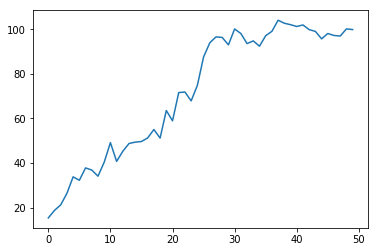

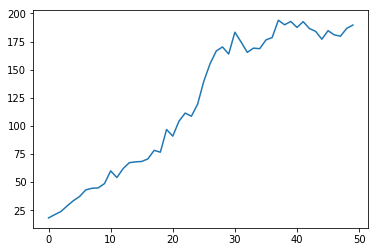

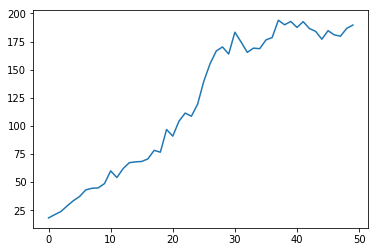

In [6]:
main()